In [1]:
"""
Here I will build an RNN to implement the 2-Bit Flip task. This is generally modelled after (https://direct.mit.edu/neco/article/25/3/626/7854/Opening-the-Black-Box-Low-Dimensional-Dynamics-in)
where they implement a 3-Bit flip task and then break down the phase space to interpret how the network is implementing the computation. I would eventually like to do the same in models I build to
mimic the Medulla by reproducing motor outputs, however I will start here to practice in a simpler case.
"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import zutils
import matplotlib.pyplot as plt

torch.Size([50, 100, 2])
torch.Size([50, 100, 2])


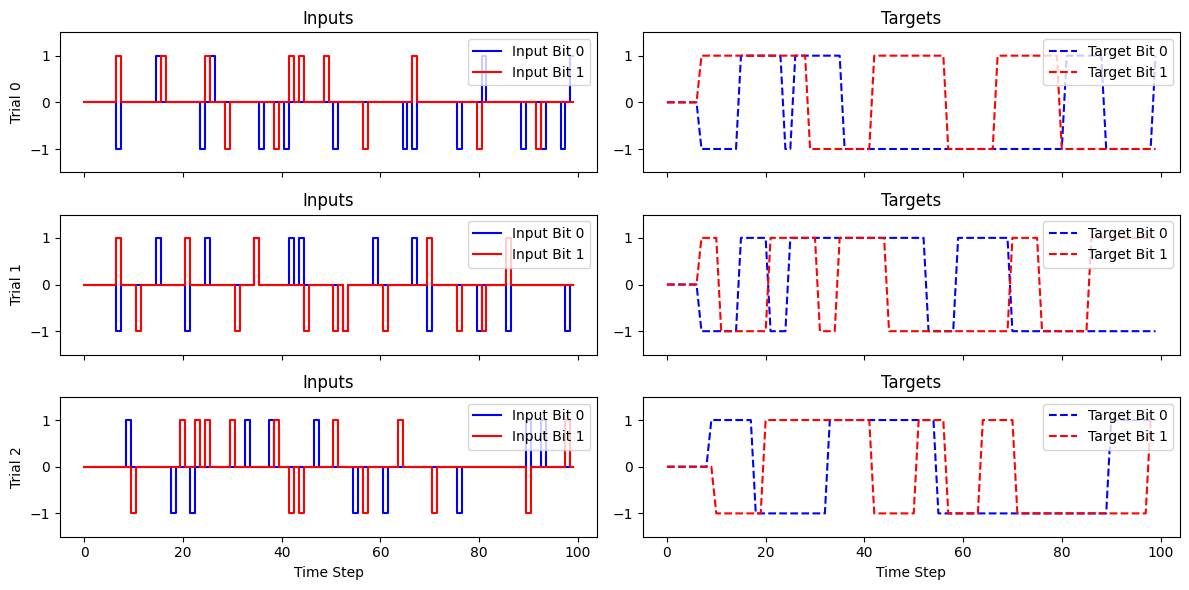

In [2]:
"""
Create and visualize the dataset
"""

X, Y = zutils.generate_2bit_flipflop_dataset(num_trials=50, trial_length=100, seed=42)
print(X.shape)  # (10, 40, 2)
print(Y.shape)  # (10, 40, 2)

zutils.plot_flipflop_trials(X, Y, num_trials_to_plot=3)


In [4]:
class FlipFlopRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, output_size=2, num_layers=1):
        super(FlipFlopRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bias=False,
                          nonlinearity='tanh')
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)  # out shape: (batch, seq_len, hidden_size)
        out = self.output_layer(out)  # out shape: (batch, seq_len, output_size)
        return out


In [6]:
# Generate toy dataset
X_train, Y_train = zutils.generate_2bit_flipflop_dataset(num_trials=2000, trial_length=100, seed=42)
X_val, Y_val = zutils.generate_2bit_flipflop_dataset(num_trials=500, trial_length=100, seed=42)
X_test, Y_test = zutils.generate_2bit_flipflop_dataset(num_trials=100, trial_length=100, seed=42)

# Initialize model
model = FlipFlopRNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

val_loss_storage = []
val_accuracy_storage = []

# Training loop
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, Y_train)
    loss.backward()
    optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_accuracy = zutils.flipflop_accuracy(val_outputs, Y_val)
        val_loss = loss_fn(val_outputs, Y_val)

        val_accuracy_storage.append(val_accuracy)
        val_loss_storage.append(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1, Train Loss: 0.9321, Val Loss: 0.8553, Val Acc: 0.0458
Epoch 2, Train Loss: 0.8542, Val Loss: 2.1509, Val Acc: 0.0485
Epoch 3, Train Loss: 2.1510, Val Loss: 0.7492, Val Acc: 0.0458
Epoch 4, Train Loss: 0.7486, Val Loss: 0.7122, Val Acc: 0.0460
Epoch 5, Train Loss: 0.7119, Val Loss: 0.9223, Val Acc: 0.0484
Epoch 6, Train Loss: 0.9214, Val Loss: 0.7360, Val Acc: 0.0476
Epoch 7, Train Loss: 0.7358, Val Loss: 0.7900, Val Acc: 0.0495
Epoch 8, Train Loss: 0.7895, Val Loss: 0.8069, Val Acc: 0.0497
Epoch 9, Train Loss: 0.8063, Val Loss: 0.8098, Val Acc: 0.0518
Epoch 10, Train Loss: 0.8093, Val Loss: 0.8045, Val Acc: 0.0543
Epoch 11, Train Loss: 0.8039, Val Loss: 0.7929, Val Acc: 0.0544
Epoch 12, Train Loss: 0.7922, Val Loss: 0.7884, Val Acc: 0.0546
Epoch 13, Train Loss: 0.7876, Val Loss: 0.7504, Val Acc: 0.0546
Epoch 14, Train Loss: 0.7494, Val Loss: 0.7295, Val Acc: 0.0547
Epoch 15, Train Loss: 0.7282, Val Loss: 0.7136, Val Acc: 0.0573
Epoch 16, Train Loss: 0.7121, Val Loss: 0.6386, V

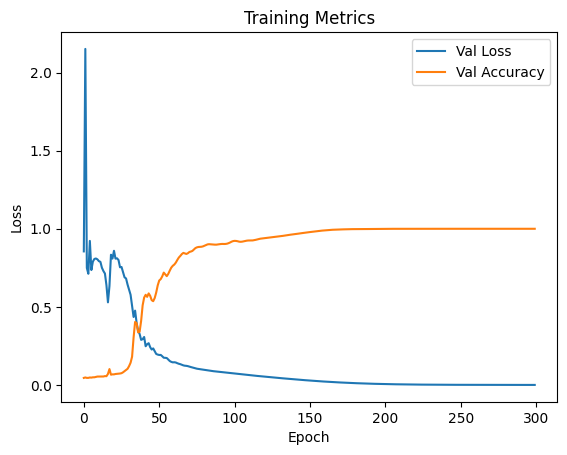

In [7]:
plt.plot(val_loss_storage, label="Val Loss")
plt.plot(val_accuracy_storage, label="Val Accuracy")
plt.title("Training Metrics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Save model
torch.save(model.state_dict(), "BitFlipRNN_100h.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
# Load saved model
model = FlipFlopRNN()
model.load_state_dict(torch.load("BitFlipRNN_100h.pth", weights_only=True))

In [8]:
model.eval()
x, y = X_test, Y_test
with torch.no_grad():
    pred = model(x)


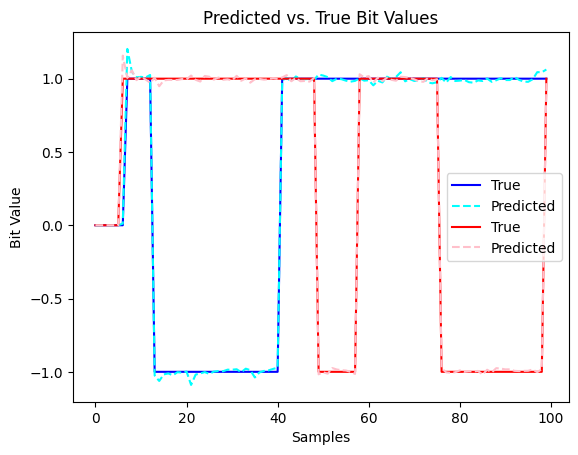

In [15]:
trial=3

plt.plot(y[trial][:,0], label="True", color="b")
plt.plot(pred[trial][:,0], linestyle="--", label="Predicted", color="cyan")

plt.plot(y[trial][:,1], label="True", color="r")
plt.plot(pred[trial][:,1], linestyle="--", label="Predicted", color="pink")

plt.xlabel("Samples")
plt.ylabel("Bit Value")
plt.legend()
plt.title("Predicted vs. True Bit Values")
plt.show()